In [1]:
import sys
import scipy.stats
from scipy.signal import coherence
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from trajectory_process import traj_process

import numpy as np
from scipy.cluster import hierarchy
from sklearn import cluster
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib notebook
import glob
import re  # Regular expression operations
import pandas as pd
from scipy import signal
import mne
from tqdm import tqdm
import os
from os.path import exists
import pickle
import statsmodels.stats.api as sms

base_dir = '/home/fu/Data/ephys/'
# base_dir = 'D:\ephys\'

import utils
import ephys
import plotting

plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.size"] = 7
# plt.rcParams["font.family"] = "Arial"

mBWfus009 = {
    'arena_0219': '2021-02-19_mBWfus009_arena_ephys',
    'ezm_0219': '2021-02-19_mBWfus009_EZM_ephys',
    'oft_0219': '2021-02-19_mBWfus009_OF_ephys',

    'arena_0226': '2021-02-26_mBWfus009_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus009_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus009_OF_ephys',

    'arena_0305_bef': '2021-03-05_mBWfus009_before_arena_ephys',
    'cage_0305': '2021-03-05_mBWfus009_cage_arena_ephys',
    'arena_0305_aft': '2021-03-05_mBWfus009_after_arena_ephys',
    'ezm_0305': '2021-03-05_mBWfus009_EZM_ephys',
    'oft_0305': '2021-03-05_mBWfus009_OF_ephys',

    'arena_0325': '2021-03-25_mBWfus009_arena_ephys',
    'epm_0325': '2021-03-25_mBWfus009_EPM_ephys'
}

mBWfus008 = {
    'arena_0219': '2021-02-19_mBWfus008_arena_ephys',
    'ezm_0219': '2021-02-19_mBWfus008_EZM_ephys',
    'oft_0219': '2021-02-19_mBWfus008_OF_ephys',

    'arena_0226': '2021-02-26_mBWfus008_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus008_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus008_OF_ephys',

    'arena_0305_bef': '2021-03-05_mBWfus008_before_arena_ephys',
    'cage_0305': '2021-03-05_mBWfus008_cage_arena_ephys',
    'arena_0305_aft': '2021-03-05_mBWfus008_after_arena_ephys',
    'ezm_0305': '2021-03-05_mBWfus008_EZM_ephys',
    'oft_0305': '2021-03-05_mBWfus008_OF_ephys',
}

mBWfus010 = {
    'arena_0219': '2021-02-19_mBWfus010_arena_ephys',
    'ezm_0219': '2021-02-19_mBWfus010_EZM_ephys',
    'oft_0219': '2021-02-19_mBWfus010_OF_ephys',

    'arena_0301_aft': '2021-03-01_mBWfus010_arena_ephys_after',
    'arena_0301_bef': '2021-03-01_mBWfus010_arena_ephys_before',
    'cage_0301': '2021-03-01_mBWfus010_cage_ephys',
    'oft_0301': '2021-03-01_mBWfus010_OF_ephys',
    'ezm_0301': '2021-03-01_mBWfus010_EZM_ephys',

    'arena_0307_bef': '2021-03-07_mBWfus010_after_arena_ephys',
    'cage_0307': '2021-03-07_mBWfus010_cage_arena_ephys',
    'arena_0307_aft': '2021-03-07_mBWfus010_after_arena_ephys',
    'ezm_0307': '2021-03-07_mBWfus010_EZM_ephys',
    'oft_0307': '2021-03-07_mBWfus010_OF_ephys',
}

mBWfus011 = {
    'arena_0226': '2021-02-26_mBWfus011_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus011_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus011_OF_ephys',

    'arena_0305_aft': '2021-03-05_mBWfus011_after_arena_ephys',
    'cage_0305': '2021-03-05_mBWfus011_cage_arena_ephys',
    'arena_0305_bef': '2021-03-05_mBWfus011_before_arena_ephys',
    'oft_0305': '2021-03-05_mBWfus011_OF_ephys',
    'ezm_0305': '2021-03-05_mBWfus011_EZM_ephys',

    'arena_0313_bef': '2021-03-13_mBWfus011_before_arena_ephys',
    'cage_0313': '2021-03-13_mBWfus011_cage_arena_ephys',
    'arena_0313_aft': '2021-03-13_mBWfus011_after_arena_ephys',
    'ezm_0313': '2021-03-13_mBWfus011_EZM_ephys',
    'oft_0313': '2021-03-13_mBWfus011_OF_ephys',
}

mBWfus012 = {
    'arena_0226': '2021-02-26_mBWfus012_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus012_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus012_OF_ephys',
}

In [2]:
animal = mBWfus009
session = 'ezm_0219'
behavior_trigger = 14.24 # time when LED is turned off
start_time = 41.0 # time when animal is put onto maze
savedir='./results_EZM/009_0219_EZM/'

exclude = [10, 21, 23, 44, 60, 61, 62, 63]

/home/fu/Data/ephys/2021-02-19_mBWfus009_EZM_ephys/ephys_processed/
total number of frames: 72809
frames to process: 45000
edited 5938 data points


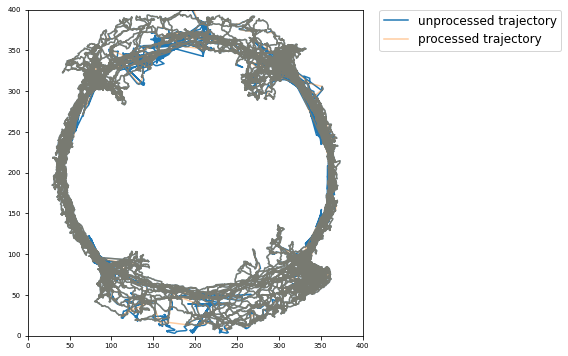

Number of open-to-closed crossings detected: 15
Number of closed-to-open crossings detected: 1
Number of lingerings in transition region detected: 84
Number of prolonged open to closed crossings detected: 25
Number of prolonged closed to open crossings detected: 39
Number of withdraws detected: 20
Number of nosedips detected: 118


In [3]:
f_behavior = 50
f_ephys = 500
behavior_window_duration = 900
ephys_window_duration = 1000
events = traj_process(base_dir, animal[session], behavior='ezm', start_time=start_time, duration=behavior_window_duration)

# ### extract overall behavioral open/close frame indices
open_idx = [i for i, el in enumerate(
    events['rois_stats']['roi_at_each_frame'][
    int(f_behavior * behavior_trigger):int(f_behavior * behavior_trigger) + f_behavior * behavior_window_duration])
            if
            el == 'open']
close_idx = [i for i, el in enumerate(
    events['rois_stats']['roi_at_each_frame'][
    int(f_behavior * behavior_trigger):int(f_behavior * behavior_trigger) + f_behavior * behavior_window_duration])
             if
             el == 'closed']
open_to_close_idx = np.array(events['transitions']['open_closed_exittime']) - int(f_behavior * behavior_trigger)
prolonged_close_to_open_idx = np.array(events['transitions']['prolonged_open_closed_exittime']) - int(
    f_behavior * behavior_trigger)
prolonged_open_to_close_idx = np.array(events['transitions']['prolonged_closed_open_exittime']) - int(
    f_behavior * behavior_trigger)

In [4]:
dataset = ephys.load_data(base_dir, animal[session])

power_mpfc = ephys.column_by_pad(ephys.get_power(dataset, 'mpfc', 'theta'))
power_vhipp = ephys.column_by_pad(ephys.get_power(dataset, 'vhipp', 'theta'))

mpfc_pads = np.array(power_mpfc.columns)
vhipp_pads = np.array(power_vhipp.columns)

2021-02-19_mBWfus009_EZM_ephys


## Phase and Time Lag Analysis

In [ ]:

totlen = len(mpfc_pads) + len(vhipp_pads)
power_corrs = np.zeros((totlen, totlen))
for i in range(totlen):
    for j in range(totlen):
        if i < len(mpfc_pads):
            siga = power_mpfc[mpfc_pads[i]]
        else:
            siga = power_vhipp[vhipp_pads[i-len(mpfc_pads)]]
        if j < len(mpfc_pads):
            sigb = power_mpfc[mpfc_pads[j]]
        else:
            sigb = power_vhipp[vhipp_pads[j-len(mpfc_pads)]]
        power_corrs[i][j] = pd.Series.corr(siga, sigb)

fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(power_corrs, vmin=np.min(power_corrs), vmax=np.max(power_corrs))

ax.set_yticks(np.arange(totlen))
ax.set_xticks(np.arange(totlen))

ax.set_yticklabels(np.concatenate((mpfc_pads, vhipp_pads)))
ax.set_xticklabels(np.concatenate((mpfc_pads, vhipp_pads)))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
    tick.label.set_rotation('vertical')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.tight_layout()
fig.colorbar(im, shrink=0.5)
plt.title('Pearson\'s Correlation between mPFC and vHPC signals', fontsize=16)
plt.ylabel('mPFC')
plt.xlabel('vHPC')
plt.show()

In [ ]:
mpfc_ch_labels, vhipp_ch_labels, FWHMs_open = plotting.plot_phase_coh_pairs(dataset, animal, session, savedir=savedir+'phase_diff_distrib_open/', band='theta', exclude=exclude,
                              srate=f_ephys, beh_srate=f_behavior, tstart=start_time, twin=behavior_window_duration, nbins=64,
                             select_idx=open_idx)

In [ ]:
mpfc_ch_labels, vhipp_ch_labels, FWHMs_closed = plotting.plot_phase_coh_pairs(dataset, animal, session, savedir=savedir+'phase_diff_distrib_closed/', band='theta', exclude=exclude,
                              srate=f_ephys, beh_srate=f_behavior, tstart=start_time, twin=behavior_window_duration, nbins=64,
                             select_idx=close_idx)

In [ ]:
### show difference of FWHM open - closed
### a positive value means open FWHM > closed FWHM on specific channel
### indicating a less consistent phase relationship
from matplotlib.colors import BoundaryNorm

# define the colormap
cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

FWHMs_diff = FWHMs_open - FWHMs_closed

# define the bins and normalize and forcing 0 to be part of the colorbar!
bounds = np.arange(-1, 1,.1)
idx=np.searchsorted(bounds,0)
bounds=np.insert(bounds,idx,0)
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(FWHMs_diff, interpolation='none',norm=norm,cmap=cmap)

ax.set_xticks(np.arange(len(vhipp_ch_labels)))
ax.set_yticks(np.arange(len(mpfc_ch_labels)))

ax.set_xticklabels(vhipp_ch_labels)
ax.set_yticklabels(mpfc_ch_labels)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
    tick.label.set_rotation('vertical')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.tight_layout()
fig.colorbar(im, shrink=0.5)
plt.title('Heatmap of FWHM differences (open-closed), all mPFC and vHPC channel pairs', fontsize=16)
plt.xlabel('vHPC')
plt.ylabel('mPFC')
plt.savefig(savedir+animal[session]+'_phasecoh_fwhm_diff.jpg', bbox_inches = 'tight')
plt.show()

In [ ]:
plotting.plot_seg_lags_pairs(dataset, animal, session, savedir+'pair_lags_closed/', 'theta', exclude, srate=500, beh_srate=50, tstart=start_time, twin=behavior_window_duration, select_idx=close_idx)

In [ ]:
plotting.plot_seg_lags_pairs(dataset, animal, session, savedir+'pair_lags_open/', 'theta', exclude, srate=500, beh_srate=50, tstart=start_time, twin=behavior_window_duration, select_idx=open_idx)

## Neural Trajectory analysis with PSID

In [5]:
import random

import PSID
from PSID.evaluation import evalPrediction

In [6]:
segs = []
maxtime = int((behavior_trigger + behavior_window_duration) * f_behavior)
pos = 0
segstart = pos

while pos < maxtime:
    while (not pos in open_idx) and (pos < maxtime):
        pos += 1
    start = pos
    count = 0
    if pos in open_idx:
        while count < int(f_behavior * 2.0) and pos in open_idx:
            count += 1
            pos += 1
    if count >= int(f_behavior * 2.0):
        segs.append(start)
    else:
        pos += 1
    pos += random.randint(1,5)
        
open_crops = [(int(segs[i] / f_behavior * f_ephys), int((segs[i] / f_behavior + 2.0) * f_ephys)) for i in range(len(segs))]
N_total = len(open_crops)
print('Number of open region time segments sampled: ', N_total)

Number of open region time segments sampled:  177


In [7]:
z = []

## center of circle: x=202, y=204
## inner radius = 144
## outer radius = 176
median_r = 160
center_x = 202
center_y = 204

for i in range(N_total):
    headpos = []
    ephys_start, ephys_end = open_crops[i]
    for ephys_ind in range(ephys_start, ephys_end):
        traj_ind = int((ephys_ind / f_ephys + behavior_trigger) * f_behavior)
        curr_x = events['movement']['calib_traj_x'][traj_ind]
        curr_y = events['movement']['calib_traj_y'][traj_ind]
        dist = np.sqrt((curr_x - center_x) ** 2 + (curr_y - center_y) ** 2) - median_r
        headpos.append(dist)
    z.append(np.expand_dims(np.array(headpos), axis=1))

In [8]:
power_mpfc_use = power_mpfc.drop(columns=[i for i in exclude if i in list(mpfc_pads)])
power_vhipp_use = power_vhipp.drop(columns=[i for i in exclude if i in list(vhipp_pads)])
y = []

for i in range(N_total):
    ephys_start, ephys_end = open_crops[i]
    power_mpfc_crop = np.array(power_mpfc_use)[ephys_start:ephys_end,:]
    power_vhipp_crop = np.array(power_vhipp_use)[ephys_start:ephys_end,:]
    curr_powers = np.concatenate([power_mpfc_crop, power_vhipp_crop], axis=1)
    y.append(curr_powers)

In [11]:
# Separate data into training and test data:
TrainInds = np.random.choice(len(y), int(0.5*len(y)), replace=False)
TestInds = [ti for ti in np.arange(len(y)) if ti not in TrainInds]
y_train = [y[ti] for ti in TrainInds]
z_train = [z[ti] for ti in TrainInds]
y_test = [y[ti] for ti in TestInds]
z_test = [y[ti] for ti in TestInds]

In [12]:
for search_i in range(2,21):
    idSys = PSID.PSID(y_train, z_train, nx=2, n1=2, i=search_i)

    for ti in range(len(y_test)):
        zPredThis, yPredThis, xPredThis = idSys.predict(y_test[ti])
        if ti == 0:
            zTestA = z_test[ti]
            zPredA = zPredThis
        else:
            zTestA = np.concatenate( (zTestA, z_test[ti]), axis=0)
            zPredA = np.concatenate( (zPredA, zPredThis), axis=0)

    CCTrialBased = evalPrediction(zTestA, zPredA, 'CC')
    print(search_i)
    print('Behavior decoding CC (trial-based learning/decoding):\n  PSID => {:.3g}'.format(np.mean(CCTrialBased)) )

2
Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.141
3
Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.125
4
Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.0967
5
Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.127
6
Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.137
7
Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.125
8
Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.126
9
Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.129
10
Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.113
11
Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.121
12
Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.107
13
Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.102
14
Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.112
15
Behavior decoding CC (trial-based learning/decoding):
 

In [13]:
search_i = 6
idSys = PSID.PSID(y_train, z_train, nx=2, n1=2, i=search_i)

for ti in range(len(y_test)):
    zPredThis, yPredThis, xPredThis = idSys.predict(y_test[ti])
    if ti == 0:
        zTestA = z_test[ti]
        zPredA = zPredThis
    else:
        zTestA = np.concatenate( (zTestA, z_test[ti]), axis=0)
        zPredA = np.concatenate( (zPredA, zPredThis), axis=0)

CCTrialBased = evalPrediction(zTestA, zPredA, 'CC')
print(search_i)
print('Behavior decoding CC (trial-based learning/decoding):\n  PSID => {:.3g}'.format(np.mean(CCTrialBased)) )

6
Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.137


In [113]:
dip_crop = []
durations = []

for i in range(len(events['transitions']['nosedip_starttime'])):
    true_starttime = events['transitions']['nosedip_starttime'][i] - behavior_trigger * f_behavior
    true_stoptime = events['transitions']['nosedip_stoptime'][i] - behavior_trigger * f_behavior
    duration = true_stoptime - true_starttime
    if duration <= 1.9 * f_behavior:
        cropstart = int((true_starttime / f_behavior - 0.1)* f_ephys)
        cropend = int((true_starttime / f_behavior + 1.9) * f_ephys)
        dip_crop.append((cropstart, cropend))
        durations.append(duration / f_behavior)
    
print(len(dip_crop))
y_dip = []
z_dip = []

for i in range(len(dip_crop)):
    ephys_start, ephys_end = dip_crop[i]
    power_mpfc_crop = np.array(power_mpfc_use)[ephys_start:ephys_end,:]
    power_vhipp_crop = np.array(power_vhipp_use)[ephys_start:ephys_end,:]
    curr_powers = np.concatenate([power_mpfc_crop, power_vhipp_crop], axis=1)
    y_dip.append(curr_powers)

    headpos = []
    for ephys_ind in range(ephys_start, ephys_end):
        traj_ind = int((ephys_ind / f_ephys + behavior_trigger) * f_behavior)
        curr_x = events['movement']['calib_traj_x'][traj_ind]
        curr_y = events['movement']['calib_traj_y'][traj_ind]
        dist = np.sqrt((curr_x - center_x) ** 2 + (curr_y - center_y) ** 2) - median_r
        headpos.append(dist)
    z_dip.append(np.expand_dims(np.array(headpos), axis=1))

76


(-0.8, 0.8)

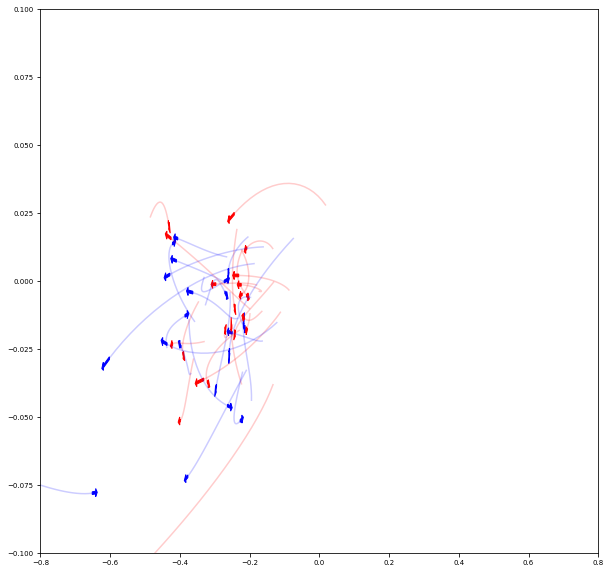

In [155]:
plt.figure(figsize=(10,10))
for i in range(len(y_dip)):
    if i>40:
        break
    zPredThis, yPredThis, xPredThis = idSys.predict(y_dip[i])
    onset = 50
    ret = int(onset + durations[i] * f_ephys)
    
    endpoint_onset_x = xPredThis[onset+19, 0]
    endpoint_onset_y = xPredThis[onset+19, 1]
    if np.sqrt(endpoint_onset_x**2 + endpoint_onset_y**2) > 0.2:
        plt.plot(xPredThis[onset:onset+20, 0], xPredThis[onset:onset+20, 1], color='b', alpha=0.2)
        deltax_onset = xPredThis[onset+19, 0] - xPredThis[onset+18, 0]
        deltay_onset = xPredThis[onset+19, 1] - xPredThis[onset+18, 1]
        plt.arrow(xPredThis[onset+18, 0], xPredThis[onset+18, 1], deltax_onset, deltay_onset, width = 0.001, color='b')
    
    endpoint_ret_x = xPredThis[ret-1,0]
    endpoint_ret_y = xPredThis[ret-1,1]
    if np.sqrt(endpoint_ret_x**2 + endpoint_ret_y**2) > 0.2:
        plt.plot(xPredThis[ret-20:ret, 0], xPredThis[ret-20:ret, 1], color='r', alpha=0.2)
        deltax_return = xPredThis[ret-1, 0] - xPredThis[ret-2, 0]
        deltay_return = xPredThis[ret-1, 1] - xPredThis[ret-2, 1]
        plt.arrow(xPredThis[ret-2, 0], xPredThis[ret-2, 1], deltax_return, deltay_return, width = 0.001, color='r')
plt.ylim(-0.1, 0.1)
plt.xlim(-0.8, 0.8)